# Série Temporais - Aplicação do Modelo Seasonal ARIMA

## Table of contents
* [Importação de Dados](#1)
* [Decomposição sazonal](#2)
* [Autocorrelação e Autocorrelação Parcial](#3)
* [Seleção Automática dos Parâmetros](#4)
* [Ajustando o Modelo SARIMA](#5)
* [Validando as Previsões](#6)
* [Visualizando as Previsões](#7)
* [Trabalhando com dados estacionários](#8)
* [Representação Final](#9)

----
### Bibliotecas e dependências:

In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib
%matplotlib inline
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import warnings
warnings.filterwarnings('ignore')

### Importação dos Datasets <a name="1"></a>

O conjunto de dados está divididos em 2 arquivos, um com o período de 2001 a 2012 e outro de 2013 a 2019. Será necessário selecionar as colunas de interesse (MÊS, PRODUTO e PREÇO MÉDIO REVENDA) e realizar a concatenação de ambos para podermos iniciar nossas análises.

In [580]:
# Dataset 1
df1 = pd.read_excel(r'.\Brasil.xlsx', skiprows=12)
df1 = df1.iloc[:,[0,1,4]]
df1 = df1[df1['PRODUTO'] == 'ETANOL HIDRATADO']
df1 = df1.rename(columns={'PRECO MÉDIO REVENDA': 'PREÇO MÉDIO REVENDA'})
df1 = df1.sort_values('MÊS')

# Dataset 2
df2 = pd.read_excel(r'.\MENSAL_BRASIL-DESDE_Jan2013.xlsx', skiprows=15)
df2 = df2.iloc[:,[0,1,4]]
df2 = df2[df2['PRODUTO'] == 'ETANOL HIDRATADO']
df2 = df2.sort_values('MÊS')

# Concatenação
df = pd.concat([df1,df2], axis=0).rename(columns={'MÊS':'ANO'}).set_index('ANO').drop('PRODUTO', axis=1)
df.head()

,PREÇO MÉDIO REVENDA
ANO,
2001-07-01,1.0093
2001-08-01,1.0143
2001-09-01,1.0265
2001-10-01,1.0391
2001-11-01,1.0326


É importante a visualização gráfica para observar o comportamento dos nossas dados.

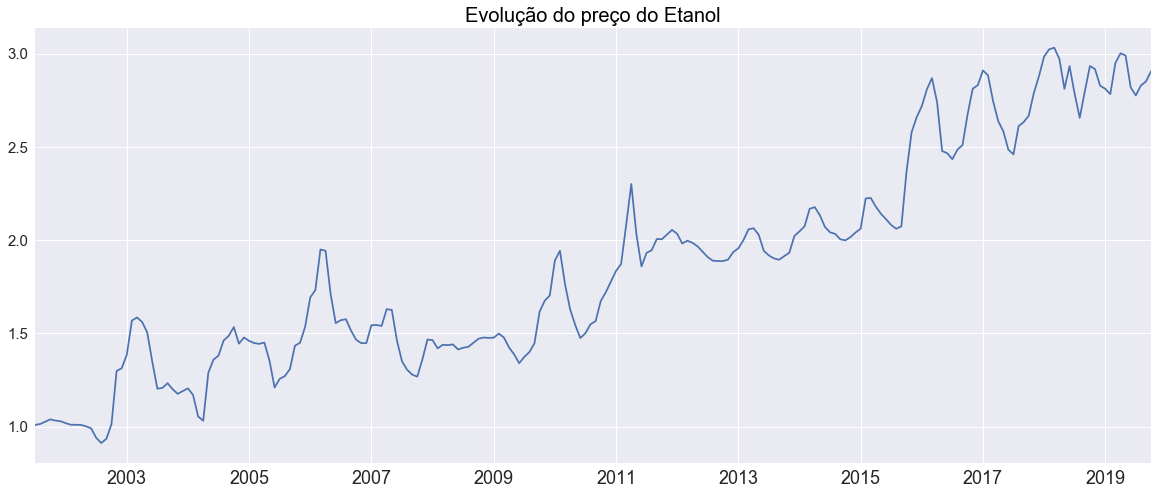

In [573]:
df.plot(title='Série Histórica', legend=False, figsize=(20,8))

plt.title('Evolução do preço do Etanol', size=20)
plt.xlabel('')
plt.xticks(fontsize=18)
plt.yticks(fontsize=15)
plt.show()

# Utilizando decomposição sazonal por meio de médias movéis <a name="2"></a>

Séries Temporais, em geral, podem ser classificadas como aditivas ou multiplicativas mas ambas possuem os mesmos 3 componentes:

- <u>Tendência</u>, que representa a direção geral como os dados se desenvolvem ao longo do tempo;
- <u>Sazonalidade</u>, padrões de como os dados mudam em relação a período determinado;
- <u>Erro</u>, são variações irregulares não explicadas pela tendência ou sazonalidade.

No caso de uma Séria Temporal Aditiva, um modelo pode ser explicado pela fórmula:

    Y[t] = T[t] + S[t] + e[t]
    
    Onde:
        Y[t] : Saída do Modelo
        T[t] : Componente de Tendência do modelo
        S[t] : Componente de Sazonalidade do modelo
        e[t] : erro ou resíduo

É possível, e muito importante, analisarmos esses três componentes separadamente de modo a avaliar melhor o comportamento individual de cada item, para isso iremos realizar sua decomposição. Como nossos dados tratam-se de observações mensais, a frequência passada como parâmtro será 12, o que significa que para cada ponto iremos analisar a média dos 6 meses anteriores e 6 posteriores.

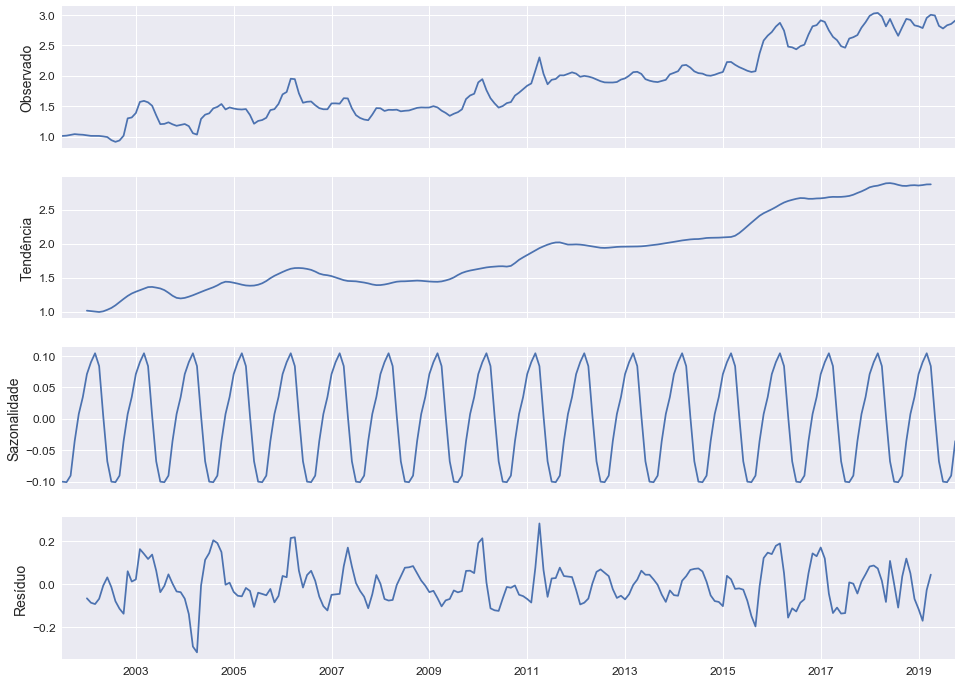

In [488]:
res = sm.tsa.seasonal_decompose(df,freq=12)
def plot_decompose(res):
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,12))
    
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observado')
    
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Tendência')
    
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Sazonalidade')
    
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Resíduo')
    
    plt.xlabel('')
    
plot_decompose(res)

É possível identificar que nossos dados possuem uma clara tendência de crescimento. Quanto à sazonalidade, o gráfico, a princípio, pode ser um pouco difícil de interpretar, mas irei tentar esclarecer com um exemplo prático: 

Observando-se os círculos "o" no gráfico abaixo, podemos indentificar que em Fevereiro de 2002 houve um aumento de 10% no valor do preço do etanol, portanto Fevereiro possui um efeito sazonal de +10%, enquanto Junho possui um efeito sazonal de -10% no preço. É possível observar novamente os mesmos meses em pontos mais avançados na curva, anotados por "o*".

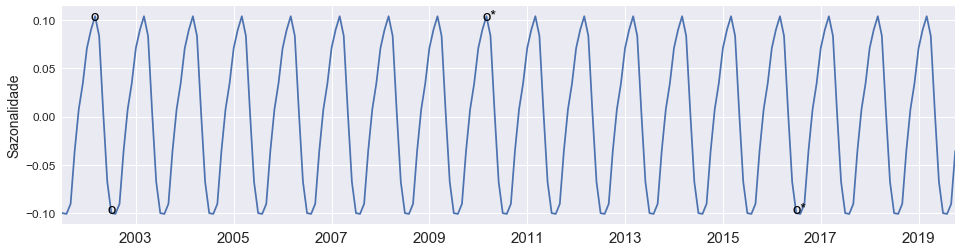

In [491]:
import datetime as dt

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,4))
res.seasonal.plot(ax=ax, legend=False)
ax.set_ylabel('Sazonalidade')
ax.set_xlabel('')
plt.xticks(fontsize=15)

ax.annotate('o',fontsize=15 
            ,xy=(dt.datetime(2002,2,1), 0.1)) # Fevereiro/2002      
ax.annotate('o', fontsize=15
            ,xy=(dt.datetime(2002,6,1), -0.10)) # Junho/2002
ax.annotate('o*',fontsize=15 
            ,xy=(dt.datetime(2010,2,1), 0.1)) # Fevereiro/2010
ax.annotate('o*', fontsize=15
            ,xy=(dt.datetime(2016,6,1), -0.10)) # Junho/2016
plt.show()

# Autocorrelação e Autocorrelação Parcial <a name="3"></a>

Outra análise importante a se fazer diz respeito quanto à Função de Autocorrelação (ACF) e Função de Autocorrelação Parcial (PACF). O gráfico de Autocorrelação mostra a correlação dos dados de uma série temporal e os seus próprios "lags". Um *lag* = 1 mostra a correlação entre Y[t] e Y[t-1]. 

No gráfico ACF denota-se que há um pico no lag=1 que dimiui de forma constante sutil ao longo dos vários lags, explicado pela tendência, e pode-se observar também um leve movimento de "onda", que pode ser explicado pela sazonalidade. Uma linha vermelha foi inserida para auxiliar a visualização. Este padrão em que há um pico no lag=1 que diminui lentamente ao longo dos vários lags pode indicar também que os dados não são estacionários e devem, primeiro, ser transformados, porém não iremos fazê-lo neste momento. 

A área em azul representa o nível de significância, coeficientes dentro desta área apresentam correlação fraca aos respectivos lags e não são considerados significantes paras a análise.

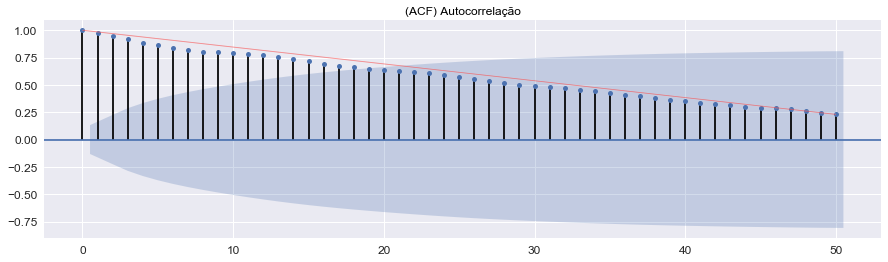

In [456]:
fig, ax = plt.subplots(1,1,figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(df, lags=50, ax=ax)
plt.title(r'(ACF) Autocorrelação')

ax.annotate('', xy=(0, 1), xycoords='data'
              ,xytext=(50, 0.23), textcoords='data'
              ,arrowprops=dict(facecolor='red', width=0.9, headwidth=0.1, headlength=0.1, alpha=0.5))


plt.show()

Contrariamente à Autocorrelação, a Função de Autocorrelação Parcial remove o efeito dos outros dados, dando a correlação pura  apenas entre dois *lags*.

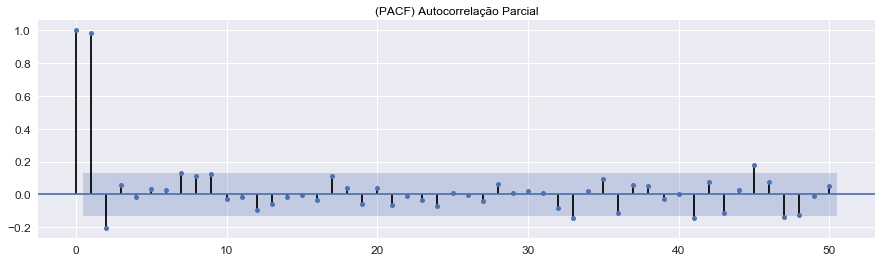

In [457]:
fig, ax = plt.subplots(1,1,figsize=(15,4))
fig = sm.graphics.tsa.plot_pacf(df, lags=50, ax=ax)
plt.title(r'(PACF) Autocorrelação Parcial')
plt.show()

Utilizamos estas duas funções para escolher corretamente a ordem para os componentes AR(Autoregression) e MA(Moving Average) do modelo ARIMA. 

    No modelo ARIMA: order(p,d,q)

Para a ordem p (tendência), olhamos o gráfico ACF e pegamos um valor de lag significante anterior ao primeiro insignificante, de acordo com a área em azul. Para a ordem q (sazonalidade), olhamos o gráfico PACF e fazems o mesmo. Lembrando que isso deverá ser realizado somente após os dados da série estarem transformados em estacionários, os gráficos acima foram realizados sobre os dados não-estacionários.

# Seleção dos melhores parâmetros com o "auto_arima" <a name="4"></a>
Continuaremos com nossos dados sem transformação e iremos selecionar o modelo automaticamente através da função "auto_arima", que irá nos entregar os melhores componentes para o modelo ARIMA e suas estatísticas.

In [150]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(df,
                     start_p=0, start_q=0, 
                     max_p=3, max_q=3,
                     start_P=0, start_Q=0, 
                     max_P=3, max_Q=3,
                     d=1, max_d=1,
                     D=1, max_D=1,
                     m=12,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-304.302, BIC=-297.636, Fit time=0.072 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-368.545, BIC=-355.214, Fit time=1.412 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-446.183, BIC=-432.852, Fit time=1.697 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-306.301, BIC=-302.968, Fit time=0.038 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-315.803, BIC=-305.805, Fit time=0.076 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=-392.524, BIC=-375.861, Fit time=1.793 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 1, 0, 12); AIC=-402.301, BIC=-382.305, Fit time=5.366 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 1, 1, 12); AIC=-434.647, BIC=-411.318, 

### Resumo das estatísticas

Em geral, as duas estatísticas levadas em consideração para a seleção do modelo - de tal forma que quanto menor o valor, melhor - são:

- AIC: Akaike Information Criteria
- BIC: Bayesian Information Criteria

In [151]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  220
Model:             SARIMAX(2, 1, 1)x(3, 1, 1, 12)   Log Likelihood                 233.098
Date:                            Sat, 07 Dec 2019   AIC                           -448.195
Time:                                    18:52:18   BIC                           -418.201
Sample:                                         0   HQIC                          -436.066
                                            - 220                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.002      0.536      0.592      -0.003       0.005
ar.L1         -0.2543      0.188     -1.352      0.177      -0.623       0.114
ar.L2         -0.1206      0.088     -1.378      0.168      -0.292       0.051
ma.L1          0.5791      0.188      3.080      0.002       0.211       0.948
ar.S.L12      -0.1347      0.107     -1.264      0.206      -0.344       0.074
ar.S.L24      -0.1433      0.107     -1.337      0.181      -0.353       0.067
ar.S.L36      -0.1693      0.124     -1.360      0.174      -0.413       0.075
ma.S.L12      -0.8516      0.112     -7.626      0.000      -1.071      -0.633
sigma2         0.0055      0.000     12.284      0.000       0.005       0.006
===================================================================================
Ljung-Box (Q):                       39.33   Jarque-Bera (JB):                30.16
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.30
Prob(H) (two-sided):                  0.55   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Ajustando o modelo SARIMA <a name="5"></a>
Após as diversas iterações que duraram pouco mais de 4 minutos, o modelo indicado foi o "SARIMAX(2, 1, 1)x(3, 1, 1, 12)". Observe que o "X" em SARIMAX exite pois é possível utilizar uma séria "exógena", ou externa, que não será o nosso caso. Iremos aplicar o modelo SARIMA (Seasonal Autoregressive Integrated Moving Average).

In [300]:
mod = sm.tsa.statespace.SARIMAX(df
                               ,order=(2, 1, 1)
                               ,seasonal_order=(3, 1, 1, 12)
                               ,enforce_stationarity=False
                               ,enforce_invertibility=False
                               )
results = mod.fit()
print(results.summary()) 

                                 Statespace Model Results                                 
Dep. Variable:                PREÇO MÉDIO REVENDA   No. Observations:                  220
Model:             SARIMAX(2, 1, 1)x(3, 1, 1, 12)   Log Likelihood                 200.594
Date:                            Sun, 08 Dec 2019   AIC                           -385.187
Time:                                    10:42:51   BIC                           -360.148
Sample:                                07-01-2001   HQIC                          -375.026
                                     - 10-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1205      0.240     -0.502      0.616      -0.591       0.350
ar.L2         -0.1878      0.100   

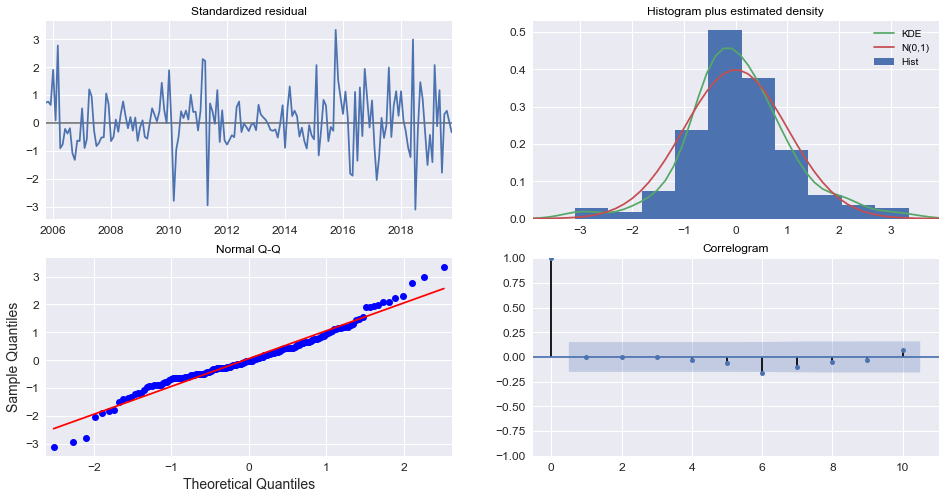

In [301]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Aqui nossa principal preocupação deve ser de garantir que os resíduos do modelo não são correlacionados e igualmente distribuídos. Se isto não for alcançado, é indicativo de que os parâmetros podem ser melhorados.

No gráfico do canto superior direito, quando a linha vermelha do KDE (Kernel Density Estimation) está próxima da linha verde N(0,1), que significa "Distribuição Normal com média 0 e desvio padrão 1", é um bom indicativo de que os resíduos são igualmente distribuídos.

No canto inferior esquerdo, o gráfico mostra que a distribuição ordenada dos resíduos seguem a linha de tendência das amostras tiradas de uma distribuição normal com N(0, 1), com alguns desvios.

No gráfico de resíduos ao longo do tempo, no canto superior esquerdo, não há nenhuma sazonalidade aparente e parece se tratar de "ruído branco". O conceito de ruído branco significa que os dados são aleatórios e não podem ser preditos, pois não seguem um padrão. Isto é confirmado pelo "correlograma", no canto inferior direito, que mostra que os resíduos possuem baixa correrelação com os próprios lags.

# Validando as previsões <a name="6"></a>

Já ajustamos o modelo e agora podemos utilizá-lo para realizar previsões. Iremos começar comparando os valores preditos com os valores reais para nos auxiliar a entender sua precisão.

Iremos utilizar "get_predition" a partir de uma data "x" e com um intervalo de confiança "conf_int".

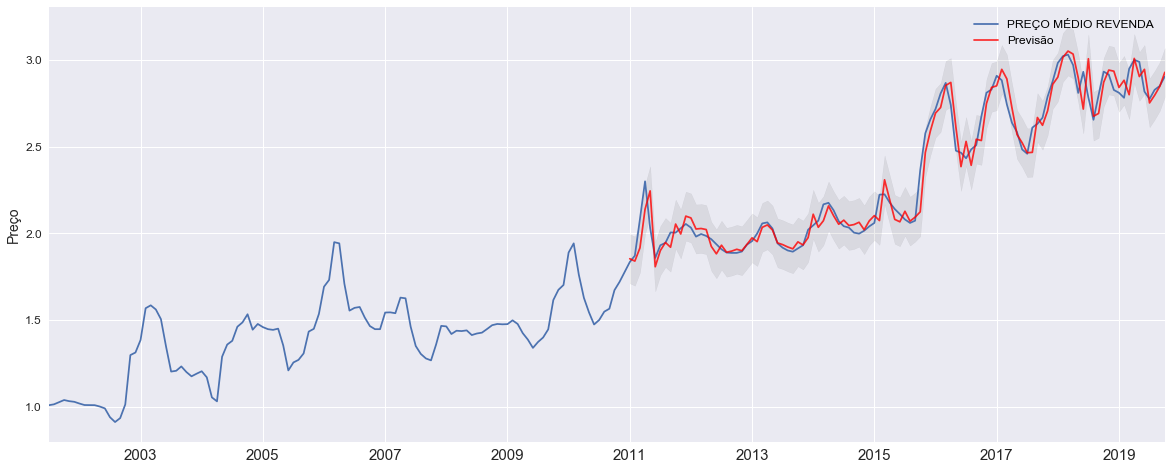

In [499]:
pred = results.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df.plot()
pred.predicted_mean.plot(ax=ax, label='Previsão', alpha=0.8, figsize=(20, 8), color='r')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.07)
ax.set_xlabel('')
ax.set_ylabel('Preço')
plt.xticks(fontsize=15)
plt.legend(fontsize=12)
plt.show()

In [500]:
y_forecasted = pred.predicted_mean
y_truth = df.loc['2011-01-01':, 'PREÇO MÉDIO REVENDA']

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('O Erro Quadrático Médio é {}'.format(round(mse, 2)))

O Erro Quadrático Médio é 0.01


In [501]:
# Desde o inicio
pred_2 = results.get_prediction(start=pd.to_datetime('2001-07-01'), dynamic=False)
y_forecasted = pred_2.predicted_mean.values
y_truth = df['2001-07-01':].values

mse = ((y_forecasted - y_truth) ** 2).mean()
print('O Erro Quadrático Médio é {}'.format(round(mse, 2)))

print('A Raiz do Erro Quadrático Médio {}'.format(round(np.sqrt(mse), 2)))

O Erro Quadrático Médio é 0.67
A Raiz do Erro Quadrático Médio 0.82


O Erro Quadrático Médio encontrado para o período apresentado no gráfico foi de 0,01, enquanto em uma previsão desde o início da série temporal foi de 0,67.

# Realizando e Visualizando Previsões <a name="7"></a>

Chegamos ao ponto principal da nossa análise, realizar as previões. Para isso iremos utilizar o atributo "get_forecast" que consegue computar os valores previstos com **n** passos a frente.

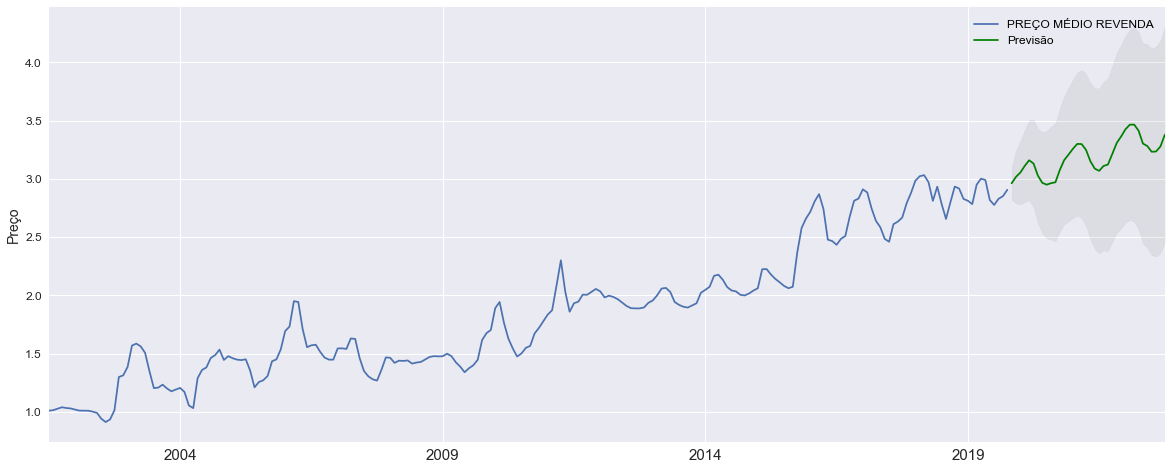

In [556]:
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()
ax = df.plot(figsize=(20, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Previsão', color='g')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.06)
ax.set_xlabel('')
ax.set_ylabel('Preço')
plt.xticks(fontsize=15)
plt.legend(fontsize=12)
plt.show()

In [557]:
pred_ci['Previsão Média'] = (pred_ci.iloc[:, 0] +  pred_ci.iloc[:, 1]) / 2
pred_ci.head(10)

,lower PREÇO MÉDIO REVENDA,upper PREÇO MÉDIO REVENDA,Previsão Média
2019-11-01,2.821505,3.102994,2.962249
2019-12-01,2.788201,3.247460,3.017830
2020-01-01,2.780640,3.329316,3.054978
2020-02-01,2.801055,3.422821,3.111938
2020-03-01,2.813465,3.506091,3.159778
2020-04-01,2.753528,3.510376,3.131952
2020-05-01,2.620376,3.435522,3.027949
2020-06-01,2.531181,3.400830,2.966005
2020-07-01,2.489815,3.410882,2.950349
2020-08-01,2.478228,3.447956,2.963092


# Trabalhando com dados estacionários <a name="8"></a>

Para séries temporais a estacionariedade é importante pois significa que as propriedades dos dados como média, variância e desvio padrão permanecem constantes ao longo do tempo. Em outras palavras, significa dizer que cada ponto nos dados deve ser independente do anterior.

Essas condições são importantes para o ajuste de um modelo linear, que é o caso do SARIMA. Para isso iremos aplicar uma transformação logarítmica.

In [444]:
from statsmodels.tsa.stattools import adfuller

def teste_estaci(data):
    p_val = adfuller(data.iloc[:,0])[1]
    if p_val >= 0.05:
        print("Série temporal não é estacionária. Adfuller p-value = {}".format(p_val))
    else:
        print("Série temporal é estacionária. Adfuller p-value = {}".format(p_val))
        
teste_estaci(df) 

Série temporal não é estacionária. Adfuller p-value = 0.936386848532691


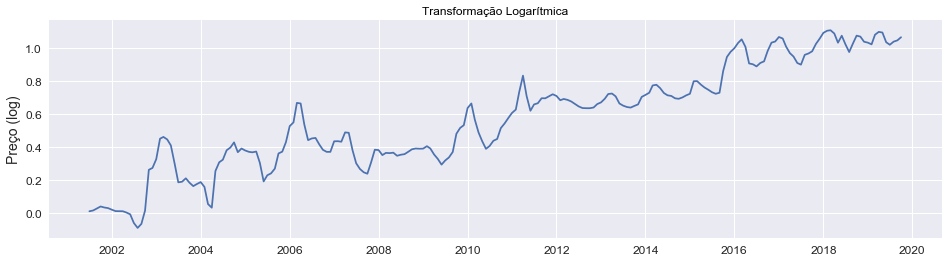

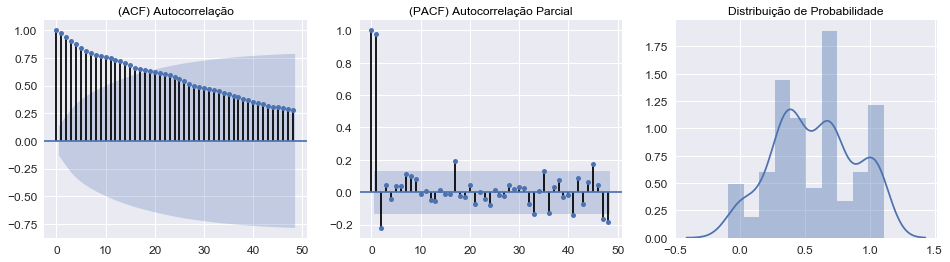

In [451]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_data_properties(data, ts_plot_name='Série Temporal'):

    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title(ts_plot_name)
    plt.ylabel(r'Preço (log)')
    plt.xlabel('')
    fig, axes = plt.subplots(1,3,squeeze=False)
    fig.set_size_inches(16,4)
    plot_acf(data, ax=axes[0,0], lags=48);
    plot_pacf(data, ax=axes[0,1], lags=48);
    sns.distplot(data, ax=axes[0,2])
    axes[0,0].set_title(r'(ACF) Autocorrelação')
    axes[0,1].set_title(r'(PACF) Autocorrelação Parcial')
    axes[0,2].set_title('Distribuição de Probabilidade')
    
log_transformed_data = np.log(df)
plot_data_properties(log_transformed_data, 'Transformação Logarítmica')

In [445]:
teste_estaci(log_transformed_data)

Série temporal não é estacionária. Adfuller p-value = 0.7146342069178622


A tranformação logarítmica por si só ainda não foi capaz de tornar os dados estacionários, ainda será necessário remover o fator de sazonalidade. Para isso é necessário calcular a diferença entre **y** a um dado **tempo = t** e **y** em **tempo = t - x**:

    Ex: diff[1] = y[t] — y[t-1]

Esse procedimento remove componentes da série temporal e a transforma em estacionária. Para remover a sazonalidade, utilizaremos a diferenciação da 12ª, devido a sazonalide mensal.

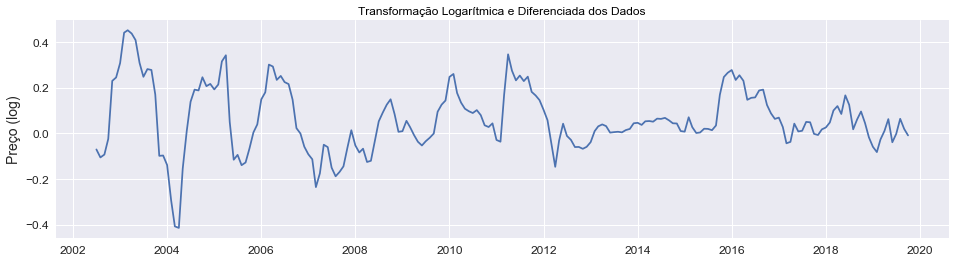

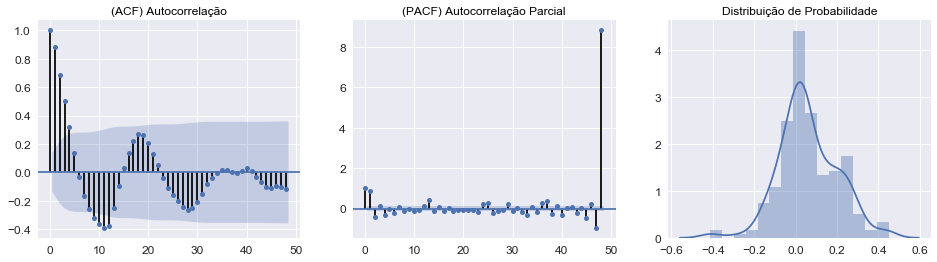

In [510]:
logged_diffed_data = log_transformed_data.diff(12)[12:]
plot_data_properties(logged_diffed_data, 'Transformação Logarítmica e Diferenciada dos Dados')

In [511]:
teste_estaci(logged_diffed_data)

Série temporal é estacionária. Adfuller p-value = 0.035293920501283514


Perceba que ao ajustar o modelo nos dados apenas com transformação logarítmica nos iremos definir os parâmtetros d=1 e D=1 e i algorímito irá realizar a diferenciação para nós. Abaixo uma aplicação parecida com o "auto_arima", porém construída em uma função personalizada.

In [582]:
def best_sarima_model(train_data,p,q,P,Q,d=1,D=1,s=12):
    best_model_aic = np.Inf 
    best_model_bic = np.Inf 
    best_model_hqic = np.Inf
    best_model_order = (0,0,0)
    models = []
    for p_ in p:
        for q_ in q:
            for P_ in P:
                for Q_ in Q:
                    try:
                        no_of_lower_metrics = 0
                        model = sm.tsa.statespace.SARIMAX(endog=train_data,order=(p_,d,q_), seasonal_order=(P_,D,Q_,s),
                                        enforce_invertibility=False).fit()
                        models.append(model)
                        if model.aic <= best_model_aic: 
                            no_of_lower_metrics+=1
                        if model.bic <= best_model_bic: 
                            no_of_lower_metrics+=1
                        if model.hqic <= best_model_hqic:
                            no_of_lower_metrics+=1
                        if no_of_lower_metrics >= 2:
                            best_model_aic = np.round(model.aic,2)
                            best_model_bic = np.round(model.bic,2)
                            best_model_hqic = np.round(model.hqic,2)
                            best_model_order = (p_,d,q_) 
                            best_model_seasonal_order = (P_,D,Q_,s)
                            current_best_model = model
                            models.append(model)
                            print("Melhor modelo até agora: SARIMA" +  str(best_model_order) + 'x' + str(best_model_seasonal_order) +
                                  " AIC:{} BIC:{} HQIC:{}".format(best_model_aic,best_model_bic,best_model_hqic)+
                                  " resid:{}".format(np.round(np.exp(current_best_model.resid).mean(),3)))

                    except:
                        pass

    print('\n')
    print(current_best_model.summary())                
    return current_best_model, models 

In [583]:
%%time
best_model, models = best_sarima_model(train_data=log_transformed_data,p=range(3),q=range(3),P=range(3),Q=range(3))

Melhor modelo até agora: SARIMA(0, 1, 0)x(0, 1, 0, 12) AIC:-523.67 BIC:-520.34 HQIC:-522.32 resid:1.002
Melhor modelo até agora: SARIMA(0, 1, 0)x(0, 1, 1, 12) AIC:-654.05 BIC:-647.39 HQIC:-651.36 resid:1.002
Melhor modelo até agora: SARIMA(0, 1, 0)x(1, 1, 2, 12) AIC:-657.37 BIC:-644.04 HQIC:-651.98 resid:1.002
Melhor modelo até agora: SARIMA(0, 1, 0)x(2, 1, 1, 12) AIC:-658.94 BIC:-645.6 HQIC:-653.54 resid:1.002
Melhor modelo até agora: SARIMA(0, 1, 0)x(2, 1, 2, 12) AIC:-660.31 BIC:-643.64 HQIC:-653.57 resid:1.002
Melhor modelo até agora: SARIMA(0, 1, 1)x(0, 1, 1, 12) AIC:-677.49 BIC:-667.49 HQIC:-673.45 resid:1.001
Melhor modelo até agora: SARIMA(0, 1, 2)x(0, 1, 1, 12) AIC:-682.28 BIC:-668.95 HQIC:-676.89 resid:1.001
Melhor modelo até agora: SARIMA(1, 1, 1)x(0, 1, 1, 12) AIC:-682.64 BIC:-669.31 HQIC:-677.25 resid:1.001


                                 Statespace Model Results                                 
Dep. Variable:                PREÇO MÉDIO REVENDA   No. Observations:       

In [527]:
mod_2 = sm.tsa.statespace.SARIMAX(log_transformed_data
                               ,order=(1, 1, 1)
                               ,seasonal_order=(0, 1, 1, 12)
                               #,enforce_stationarity=False
                               ,enforce_invertibility=False
                               )
results_2 = mod_2.fit()
print(results_2.summary()) 

                                 Statespace Model Results                                 
Dep. Variable:                PREÇO MÉDIO REVENDA   No. Observations:                  220
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 345.320
Date:                            Sun, 08 Dec 2019   AIC                           -682.640
Time:                                    17:35:26   BIC                           -669.309
Sample:                                07-01-2001   HQIC                          -677.249
                                     - 10-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3494      0.124     -2.822      0.005      -0.592      -0.107
ma.L1          0.7365      0.092   

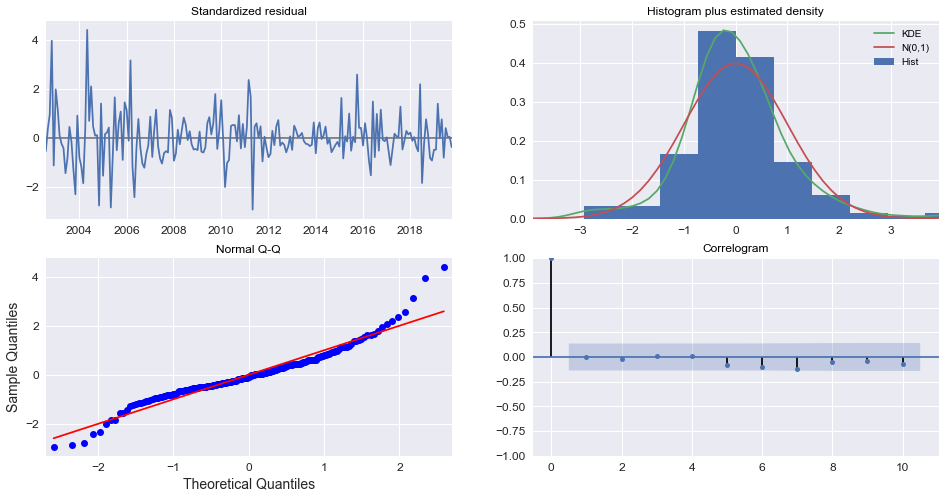

In [528]:
results_2.plot_diagnostics(figsize=(16, 8))
plt.show()

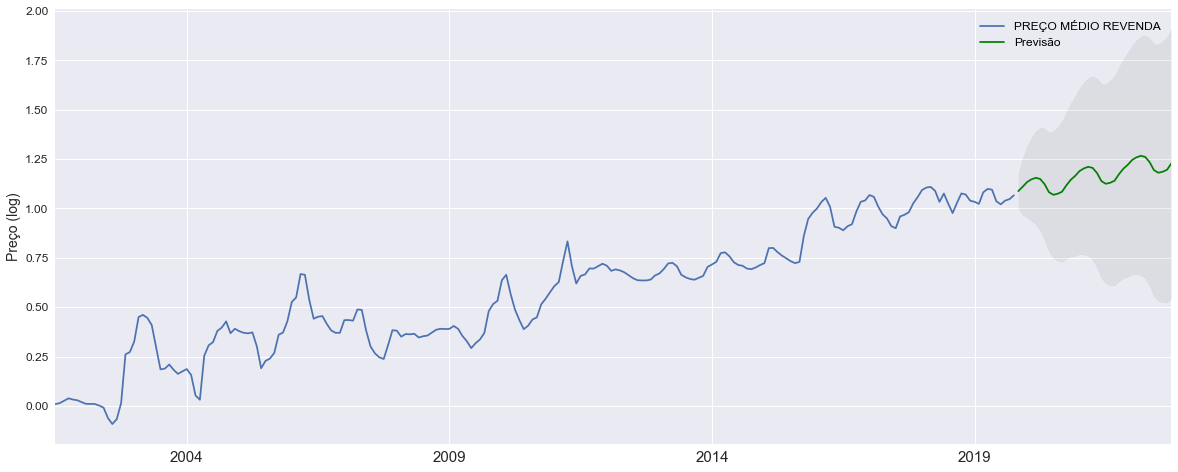

In [571]:
pred_uc_2 = results_2.get_forecast(steps=36)
pred_ci_2 = pred_uc_2.conf_int()
ax = np.log(df).plot(figsize=(20, 8))
pred_uc_2.predicted_mean.plot(ax=ax, label='Previsão', color='g')
ax.fill_between(pred_ci_2.index,
                pred_ci_2.iloc[:, 0],
                pred_ci_2.iloc[:, 1], color='k', alpha=.06)
ax.set_xlabel('')
ax.set_ylabel('Preço (log)')
plt.xticks(fontsize=15)
plt.legend(fontsize=12)
plt.show()

É interessante perceber que mesmo após as devidas transformações, os valores preditos não possuem grandes divergencias.

In [570]:
pred_ci_2['Previsão Média'] = (pred_ci_3.iloc[:, 0] +  pred_ci_3.iloc[:, 1]) / 2
pred_ci_2 = np.exp(pred_ci_2)

print('Valor Preditos sem transformação: \n\n', pred_ci['Previsão Média'].head(10))
print('\nValor Preditos com transformação logarítmica: \n\n', pred_ci_2['Previsão Média'].head(10))

Valor Preditos sem transformação: 

 2019-11-01    2.962249
2019-12-01    3.017830
2020-01-01    3.054978
2020-02-01    3.111938
2020-03-01    3.159778
2020-04-01    3.131952
2020-05-01    3.027949
2020-06-01    2.966005
2020-07-01    2.950349
2020-08-01    2.963092
Freq: MS, Name: Previsão Média, dtype: float64

Valor Preditos com transformação logarítmica: 

 2019-11-01    2.961674
2019-12-01    3.031412
2020-01-01    3.099755
2020-02-01    3.147737
2020-03-01    3.167315
2020-04-01    3.146720
2020-05-01    3.067658
2020-06-01    2.914702
2020-07-01    2.900967
2020-08-01    2.945141
Freq: MS, Name: Previsão Média, dtype: float64


# Representação Final <a name="9"></a>

Por fim, a representação gráfica das previsões com os valores retornados à escala original, após aplicada transformação exponencial.

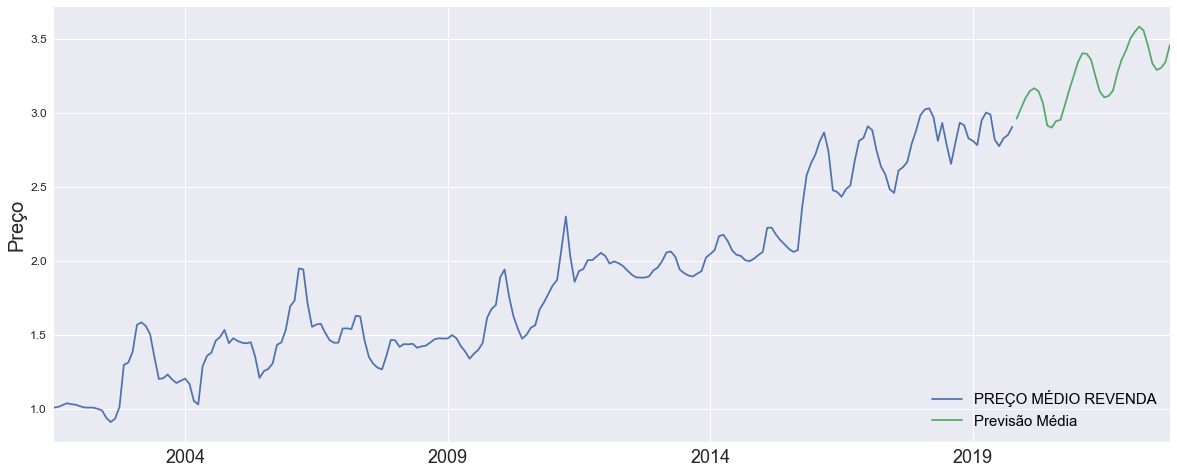

In [550]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

df.plot(ax=ax)
pred_ci_2.iloc[:,2].plot(ax=ax)


ax.set_xlabel('')
ax.set_ylabel('Preço', size=20)
plt.xticks(fontsize=18)
plt.legend(fontsize=15, loc='lower right')
plt.show()